Install Libraries

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

Import Dataset

In [18]:
df = pd.read_csv('dataset.csv')
df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct
0,45,1,Gusto,FIL,NaN,True


In [21]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23134 entries, 0 to 23133
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   word_id              23134 non-null  int64 
 1   sentence_id          23134 non-null  int64 
 2   word                 23134 non-null  object
 3   label                23134 non-null  object
 4   is_ne                1696 non-null   object
 5   is_spelling_correct  23134 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 926.4+ KB


In [20]:
def drop_null_words(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(subset=['word'])
    df_cleaned = df_cleaned.reset_index(drop=True)
    return df_cleaned

df = drop_null_words(df)

Feature Engineering / Preprocessing:

Target Features:
 - Word length
 - Vowel / Word Ratio
 - Consonant / Word Ratio
 - Look at common letters not present in filipino word (c, x, z, f, etc.)
 - Common NGram counts for Filipino and English words
    - ng
    - ch, sh, etc.
    - Filipino prefixes (um, in, etc.)
-  Check if the word is a (noun, verb, etc based on the sentence)


Note: normalize data if needed (check sklearn.preprocessing)

In [4]:
len(df["is_spelling_correct"])

23150

Length Feature

In [5]:
df['word_length'] = df['word'].apply(lambda w: len(str(w)) if isinstance(w, str) else 0)
df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length
0,45,1,Gusto,FIL,NaN,True,5


Vowel and consonant ratio

In [6]:
def vowel_consonant_ratio(word):
    if not isinstance(word, str):  ### if the word does not have alphabet
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return num_vowels / num_consonants

def vowel_word_ratio(word):
    if not isinstance(word, str):
        return 0.0
    
    vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']
    num_vowels = sum(1 for ch in word if ch.isalpha() and ch in vowels)
    num_consonants = sum(1 for ch in word)

    if num_consonants == 0:
        return 1.0 if num_vowels > 0 else 0.0
    return num_vowels / num_consonants

df['vowel_word_ratio'] = df['word'].apply(vowel_word_ratio)
df['vowel_consonant_ratio'] = df['word'].apply(vowel_consonant_ratio)

df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio
0,45,1,Gusto,FIL,NaN,True,5,0.4,0.4


Bigram

In [7]:
filipino_bigrams = ['ng', 'ka', 'in', 'ay', 'um', 'mag', 'nag', 'may', 'na', 'sa']

def count_filipino_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['filipino_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, filipino_bigrams)
)

df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count
0,45,1,Gusto,FIL,NaN,True,5,0.4,0.4,0


In [8]:
english_bigrams = [
    'th', 'sh', 'ch', 'wh', 'ed', 'ly', 'er', 
    'es', 'ou', 'ea', 'io', 'al', 'is', 'at', 
    'an', 'he'
]

def count_english_bigrams(word: str, target_bigrams: list) -> int:
    word_lower = str(word).lower()
    total_count = 0
    
    for bigram in target_bigrams:
        # Count all non-overlapping occurrences of the bigram in the word
        total_count += word_lower.count(bigram)
            
    return total_count

df['english_bigram_count'] = df['word'].apply(
    lambda x: count_filipino_bigrams(x, english_bigrams)
)

df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count
0,45,1,Gusto,FIL,NaN,True,5,0.4,0.4,0,0


Foreign Alphabet

In [9]:
foreign_letters = ['c', 'f', 'j', 'q', 'v', 'x', 'z']

def check_foreign_alphabet(word: str) -> int:
    word_lower = str(word).lower()

    for letter in word_lower:
        if letter in foreign_letters:
            return 1
    return 0

df['has_foreign_alphabet'] = df['word'].apply(check_foreign_alphabet)
df.head(1)

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,word_length,vowel_word_ratio,vowel_consonant_ratio,filipino_bigram_count,english_bigram_count,has_foreign_alphabet
0,45,1,Gusto,FIL,NaN,True,5,0.4,0.4,0,0,0


Train Test Split

- Check the sklearn to split.
- Model should be 80-20 split

In [10]:
feature_cols = ['word_length', 'vowel_word_ratio', 'vowel_consonant_ratio',
                'filipino_bigram_count', 'english_bigram_count', 'has_foreign_alphabet']
X = df[feature_cols]
y = df['label']
print(len(X),len(y))

23150 23150


In [11]:
from sklearn.model_selection import train_test_split

## Split the dataset to 15% test size and 85% train and validation size
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Split the train and validation set to 15% validation size and 85% train size
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

Imbalance Data:

Check these techniques in imblearn library:
 - SMOTE
 - Undersampling
 - Oversampling

SMOTE Sampling

In [12]:
from imblearn.over_sampling import SMOTE

smote_sampler = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote_sampler.fit_resample(
    X_train, 
    y_train
)
print("Original training set size:", len(y_train))
print("Resampled training set size:", len(y_train_resampled))

Original training set size: 16204
Resampled training set size: 37794


ML Modelling

Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_val_pred = nb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")

## Hypertune by changing model parameters if needed (var_smoothing for GaussianNB)



Validation Set Accuracy: 0.8583


Decision Trees

Model Validation:
- Confusion Matrix
- Classification report

Naive Bayes Evaluation

Test Set Accuracy: **0.8523**

Classification Report:
              precision    recall  f1-score   support

         ENG       0.63      0.46      0.53       312
         FIL       0.92      0.92      0.92      2648
         OTH       0.65      0.75      0.69       513

    accuracy                           0.85      3473
   macro avg       0.73      0.71      0.71      3473
weighted avg       0.85      0.85      0.85      3473



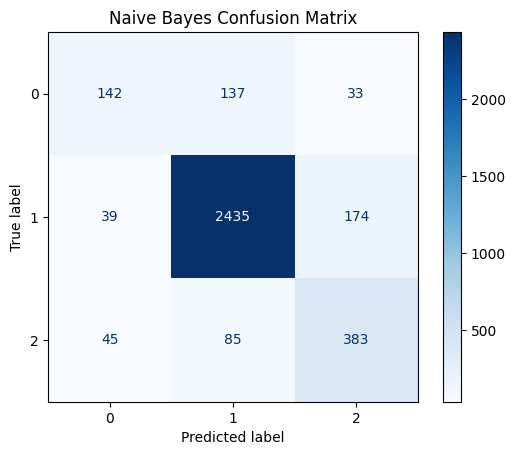

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()